# COMS4060A - Introduction of Data Visualisation & Exploration: Assignment 2 

## Group Members
* Lisa Godiwn - 2437980
* Nihal Ranchod - 2427378
* Zach Schwark - 2434346

## Coding Practices

- Dataframe `df` is the original data.
- `updated_df` is a copy of the original dataframe `df` and the continuously updated dataframe:
    - We continuously updated this dataframe, by adding columns, modifying values etc, so that we can have access to the previously performed work in one dataframe.

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from datetime import datetime

Reading in the .csv and creating a dataframe.

In [144]:
df = pd.read_csv("./nyc_taxis/nyc_taxis.csv")

df_copy = df.copy()
display(df_copy.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Question 1: Data Cleaning

1. There are several outliers in the data. Identify these and give justification for why you can remove them from the analysis. (Hint: look at trip duration, speed, distance, etc).
    1. Initial Exploration: Check for missing values, basic statistics, and unusual data points.
    2. Outlier Detection Using Boxplots:
        - **Trip Duration:** Create a boxplot to visualize the distribution of trip durations. Identify outliers as trips with durations significantly shorter or longer than the typical range, based on the Interquartile Range (IQR) method.
        - **Distance Calculation:** Calculate the trip distance using the Haversine formula, which measures the great-circle distance between the pickup and dropoff locations. Use a boxplot to detect outliers in the trip distance data.
        - **Speed Calculation:** Compute the average speed for each trip using the calculated distance and trip duration. Create a boxplot to identify trips with implausibly high or low speeds, indicating potential data entry errors or anomalies.
    3. Remove Outliers: For each of the three variables (trip duration, distance, and speed), remove data points identified as outliers using the IQR method. Outliers are defined as values outside the range of `(Q1 - 1.5 x IQR)` and `(Q3 + 1.5 x IQR)` are the first and third quartiles, respectively.

Initial Exploration: Check for missing values, basic statistics, and unusual data points.

In [145]:
display(df_copy.info())
display(df_copy.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [146]:
missing_values = df_copy.isnull().sum()
print(f'Missing values in each column: \n{missing_values}')

Missing values in each column: 
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


Trip Duration Outlier Detection

In [147]:
# Convert the trip duration to minutes
df_copy['trip_duration_min'] = df_copy['trip_duration'] / 60
display(df_copy[['trip_duration', 'trip_duration_min']].head())

,trip_duration,trip_duration_min
0,455,7.583333
1,663,11.050000
2,2124,35.400000
3,429,7.150000
4,435,7.250000


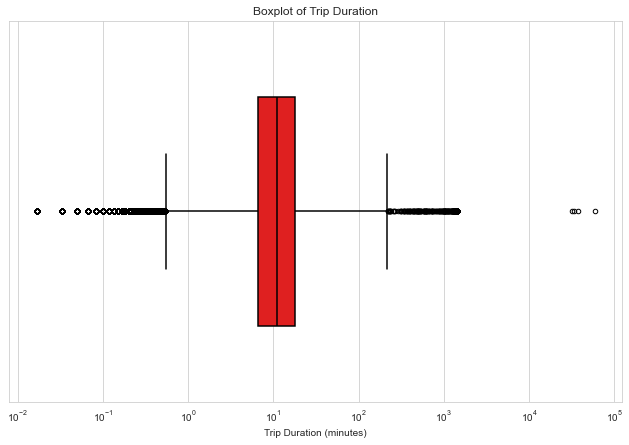

<Figure size 432x288 with 0 Axes>

In [148]:
# Plot the trip duration to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_copy["trip_duration_min"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Duration (minutes)')
plt.title('Boxplot of Trip Duration')
plt.savefig('./Plots/Plots[1]/trip_duration_boxplot.png')
plt.show()
plt.clf()

In [149]:
# Define thresholds based on boxplot (IQR method)
Q1_duration = df_copy['trip_duration_min'].quantile(0.25)
Q3_duration = df_copy['trip_duration_min'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

# Outliers are typically defined as points beyond 1.5 times the IQR
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

print(f'Q1_duration: {Q1_duration}')
print(f'Q3_duration: {Q3_duration}')
print(f'IQR_duration: {IQR_duration}')
print(f'Lower bound: {lower_bound_duration}')
print(f'Upper bound: {upper_bound_duration}')

# Number of entries before cleaning
original_count = len(df_copy)

# Remove outliers for trip duration
df_cleaned = df_copy[(df_copy['trip_duration_min'] > lower_bound_duration) & (df_copy['trip_duration_min'] < upper_bound_duration)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_duration: 6.616666666666666
Q3_duration: 17.916666666666668
IQR_duration: 11.3
Lower bound: -10.333333333333336
Upper bound: 34.866666666666674
Original number of entries: 1458644
Number of entries after cleaning: 1384424
Number of entries removed: 74220


Trip Distance Outlier Detection

In [150]:
# Calculate the distance between pickup and dropoff locations using Haversine formula
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df_cleaned['trip_distance_km'] = haversine_np(df_cleaned['pickup_longitude'], df_cleaned['pickup_latitude'], df_cleaned['dropoff_longitude'], df_cleaned['dropoff_latitude'])

display(df_cleaned[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance_km']].head())

C:\Users\nihal\AppData\Local\Temp\ipykernel_4844\342926809.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['trip_distance_km'] = haversine_np(df_cleaned['pickup_longitude'], df_cleaned['pickup_latitude'], df_cleaned['dropoff_longitude'], df_cleaned['dropoff_latitude'])


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.982155,40.767937,-73.964630,40.765602,1.497580
1,-73.980415,40.738564,-73.999481,40.731152,1.804374
3,-74.010040,40.719971,-74.012268,40.706718,1.484566
4,-73.973053,40.793209,-73.972923,40.782520,1.187842
5,-73.982857,40.742195,-73.992081,40.749184,1.098252


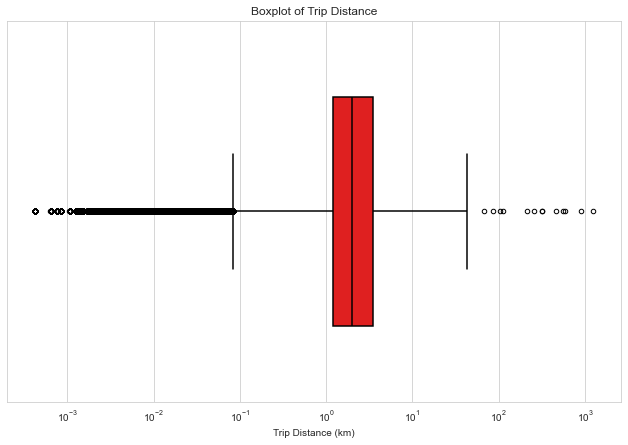

<Figure size 432x288 with 0 Axes>

In [151]:
# Plot the trip distance to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned["trip_distance_km"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Distance (km)')
plt.title('Boxplot of Trip Distance')
plt.savefig('./Plots/Plots[1]/trip_distance_boxplot.png')
plt.show()
plt.clf()

In [152]:
# Define thresholds based on boxplot (IQR method)
Q1_distance = df_cleaned['trip_distance_km'].quantile(0.25)
Q3_distance = df_cleaned['trip_distance_km'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance

lower_bound_distance = Q1_distance - 1.5 * IQR_distance
upper_bound_distance = Q3_distance + 1.5 * IQR_distance

print(f'Q1_distance: {Q1_distance}')
print(f'Q3_distance: {Q3_distance}')
print(f'IQR_distance: {IQR_distance}')
print(f'Lower bound: {lower_bound_distance}')
print(f'Upper bound: {upper_bound_distance}')

# Number of entries before cleaning
original_count = len(df_cleaned)

# Remove outliers for trip distance
df_cleaned = df_cleaned[(df_cleaned['trip_distance_km'] > lower_bound_distance) & (df_cleaned['trip_distance_km'] < upper_bound_distance)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_distance: 1.1974858282621814
Q3_distance: 3.483906343696884
IQR_distance: 2.2864205154347026
Lower bound: -2.2321449448898725
Upper bound: 6.9135371168489375
Original number of entries: 1384424
Number of entries after cleaning: 1276732
Number of entries removed: 107692


Trip Speed Outlier Detection

In [153]:
df_cleaned['speed_kmh'] = df_cleaned['trip_distance_km'] / (df_cleaned['trip_duration'] / 3600)
display(df_cleaned[['trip_distance_km', 'trip_duration', 'speed_kmh']].head())

,trip_distance_km,trip_duration,speed_kmh
0,1.497580,455,11.848984
1,1.804374,663,9.797504
3,1.484566,429,12.457894
4,1.187842,435,9.830418
5,1.098252,443,8.924851


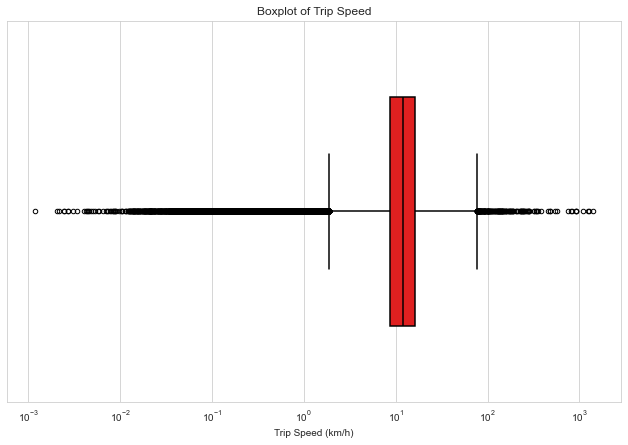

<Figure size 432x288 with 0 Axes>

In [154]:
# Plot the trip speed to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned["speed_kmh"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Speed (km/h)')
plt.title('Boxplot of Trip Speed')
plt.savefig('./Plots/Plots[1]/trip_speed_boxplot.png')
plt.show()
plt.clf()

In [155]:
# Define thresholds based on boxplot (IQR method)
Q1_speed = df_cleaned['speed_kmh'].quantile(0.25)
Q3_speed = df_cleaned['speed_kmh'].quantile(0.75)
IQR_speed = Q3_speed - Q1_speed

lower_bound_speed = Q1_speed - 1.5 * IQR_speed
upper_bound_speed = Q3_speed + 1.5 * IQR_speed

print(f'Q1_speed: {Q1_speed}')
print(f'Q3_speed: {Q3_speed}')
print(f'IQR_speed: {IQR_speed}')
print(f'Lower bound: {lower_bound_speed}')
print(f'Upper bound: {upper_bound_speed}')

# Number of entries before cleaning
original_count = len(df_cleaned)

# Remove outliers for trip speed
df_cleaned = df_cleaned[(df_cleaned['speed_kmh'] > lower_bound_speed) & (df_cleaned['speed_kmh'] < upper_bound_speed)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_speed: 8.783111873053258
Q3_speed: 16.27753997881952
IQR_speed: 7.494428105766261
Lower bound: -2.458530285596133
Upper bound: 27.51918213746891
Original number of entries: 1276732
Number of entries after cleaning: 1236820
Number of entries removed: 39912


In [156]:
# Final cleaned dataset
print("Shape of cleaned dataset: ", df_cleaned.shape)
display(df_cleaned.head())

Shape of cleaned dataset:  (1236820, 14)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_min,trip_distance_km,speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,1.497580,11.848984
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,1.804374,9.797504
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,1.484566,12.457894
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,1.187842,9.830418
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,7.383333,1.098252,8.924851


**Outlier Identification and Justification for Removal**

**1. Trip Duration Outliers**

- **Analysis**: 
  - The first and third quartiles (Q1 and Q3) of trip duration are approximately 6.62 minutes and 17.92 minutes, respectively, resulting in an Interquartile Range (IQR) of 11.3 minutes.
  - Outliers were identified as trips with durations below the lower bound of -10.33 minutes or above the upper bound of 34.87 minutes. Since negative durations are not possible, only the upper bound was considered.
  - **Results**: After applying this threshold, 74,220 entries were removed, reducing the dataset from 1,458,644 to 1,384,424 entries.

- **Justification for Removal**:
  - **Extreme durations**: Trips with durations significantly longer than the upper bound may result from data entry errors, traffic anomalies, or scenarios where the taxi meter was left running unintentionally. These extreme cases do not represent typical taxi trips and could distort the analysis of average trip times and patterns.

**2. Trip Distance Outliers**

- **Analysis**:
  - The IQR for trip distance was calculated as 2.29 km, with Q1 at 1.20 km and Q3 at 3.48 km. The lower bound was -2.23 km (which is not physically possible) and the upper bound was 6.91 km.
  - **Results**: Applying this threshold removed 107,692 entries, reducing the dataset further to 1,276,732 entries.

- **Justification for Removal**:
  - **Improbable distances**: Trips with distances far exceeding the upper bound may indicate unusually long journeys, possibly due to outliers in pickup/dropoff coordinates or GPS errors. These outliers could mislead any spatial analysis or skew results concerning the typical distance traveled in NYC.

**3. Speed Outliers**

- **Analysis**:
  - For speed, the IQR was 7.49 km/h, with Q1 at 8.78 km/h and Q3 at 16.28 km/h, leading to a lower bound of -2.46 km/h (impossible for real trips) and an upper bound of 27.52 km/h.
  - **Results**: This step removed 39,912 entries, leaving a final dataset of 1,236,820 entries.

- **Justification for Removal**:
  - **Unrealistic speeds**: Extremely high speeds may occur due to incorrect time or distance calculations, possibly indicating data errors or misrecorded trips. Similarly, very low speeds could result from trips that involved significant waiting time, or errors where the vehicle might not have moved but the trip was recorded. Removing these ensures that the analysis focuses on realistic driving conditions, leading to more accurate insights into traffic patterns and trip efficiency.

**Summary**

Outliers across trip duration, distance, and speed were systematically identified using boxplots and the IQR method. Removing these outliers is essential to maintain data integrity, representativeness, and statistical robustness in the analysis. The process ensures that the dataset accurately reflects typical taxi trips in NYC, enabling more reliable and meaningful conclusions from subsequent analyses.

### Question 2: Feature Engineering

Generate additional columns for at least these features (but you’re welcome to add more!):
- Distance of trip
- Day of week
- Average speed of trip

Note: Distance of trip and average speed of trip were already calculated in the Data Cleaning steps in Question 1.

In [157]:
display(df_cleaned[['trip_distance_km', 'speed_kmh']])

,trip_distance_km,speed_kmh
0,1.497580,11.848984
1,1.804374,9.797504
3,1.484566,12.457894
4,1.187842,9.830418
5,1.098252,8.924851
...,...,...
1458637,3.535334,16.746319
1458638,2.315993,20.139073
1458639,1.224311,5.665192
1458642,1.091878,10.538232


In [158]:
# Extract day of the week

# Convert pickup and dropoff datetime columns to datetime objects
df_cleaned['pickup_datetime'] = pd.to_datetime(df_cleaned['pickup_datetime'])
df_cleaned['dropoff_datetime'] = pd.to_datetime(df_cleaned['dropoff_datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
df_cleaned['day_of_week'] = df_cleaned['pickup_datetime'].dt.dayofweek

# Map integer values to day names
day_of_week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df_cleaned['day_of_week_str'] = df_cleaned['day_of_week'].map(day_of_week_map)

# Additional feature: Extract hour of the day
df_cleaned['pickup_hour'] = df_cleaned['pickup_datetime'].dt.hour

# Additional feature: Time of day (morning, afternoon, evening)
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_cleaned['time_of_day'] = df_cleaned['pickup_hour'].apply(time_of_day)

# All new features
display(df_cleaned[['trip_distance_km', 'speed_kmh', 'day_of_week', 'day_of_week_str', 'pickup_hour', 'time_of_day']].head())

# Save the cleaned and feature-enhanced DataFrame for further analysis
df_cleaned.to_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv', index=False)

,trip_distance_km,speed_kmh,day_of_week,day_of_week_str,pickup_hour,time_of_day
0,1.497580,11.848984,0,Monday,17,Evening
1,1.804374,9.797504,6,Sunday,0,Night
3,1.484566,12.457894,2,Wednesday,19,Evening
4,1.187842,9.830418,5,Saturday,13,Afternoon
5,1.098252,8.924851,5,Saturday,22,Night
